## Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import copy
import matplotlib.pyplot as plt

## Loading Training and Test Data
### Classification
1 for happy emotion\
0 for sad emotion

In [2]:
dirr="./emotion_classification/train/"
files=os.listdir(dirr)
X_train=[]
y_train=[]
for i in range(len(files)):
    X_train.append(plt.imread(dirr+files[i]).reshape(-1)/255)
    if files[i][10:-4]=='happy':
        y_train.append(1)
    else:
        y_train.append(0)
X_train=np.array(X_train)
y_train=np.array(y_train)

In [3]:
dirr="./emotion_classification/test/"
files=os.listdir(dirr)
X_test=[]
y_test=[]
for i in range(len(files)):
    X_test.append(plt.imread(dirr+files[i]).reshape(-1)/255)
    if files[i][10:-4]=='happy':
        y_test.append(1)
    else:
        y_test.append(0)
X_test=np.array(X_test)
y_test=np.array(y_test)

## PCA

In [4]:
pca = PCA(n_components=12)
pca.fit(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

# Model

In [5]:
def BCE(y_pred,y_true):
    return -sum(np.log(y_pred[y_true==1]))-sum(np.log(1-y_pred[y_true==0]))
    
class NN():
    def __init__(self,num_hidden=10, momentum=False):
        self.num_hidden= num_hidden
        self.gamma=0.9 if momentum else 0
        
        np.random.seed(987)
        
        self.W1=np.random.randn(12,self.num_hidden)*np.sqrt(1/6)
        self.b1=np.random.randn(self.num_hidden)*np.sqrt(1/6)
        self.W2=np.random.randn(self.num_hidden,self.num_hidden)*np.sqrt(2/self.num_hidden)
        self.b2=np.random.randn(self.num_hidden)*np.sqrt(2/self.num_hidden)
        self.W3=np.random.randn(self.num_hidden,1)*np.sqrt(1/self.num_hidden)
        self.b3=np.random.randn(1)*np.sqrt(1/self.num_hidden)
        
        self.grad_b3=0
        self.grad_W3=np.zeros((self.num_hidden,1))
        self.grad_b2=np.zeros(self.num_hidden)
        self.grad_W2=np.zeros((self.num_hidden,self.num_hidden))
        self.grad_b1=np.zeros(self.num_hidden)
        self.grad_W1=np.zeros((12,self.num_hidden))
        
    def relu(self,temp):
        temp2=copy.deepcopy(temp)
        temp2[temp2<0]=0
        return temp2
    
    def sigmoid(self,temp):
        temp2=np.exp(-temp)+1
        return 1/temp2
        
    def forward(self,data):
        self.data=data
        self.a1=(self.data@self.W1)+self.b1
        self.z1=self.relu(self.a1)
        self.a2=(self.z1@self.W2)+self.b2
        self.z2=self.relu(self.a2)
        self.a3=(self.z2@self.W3)+self.b3
        self.z3=self.sigmoid(self.a3)
        return self.z3
    
    def backward(self,y_true, lr):
        N=y_true.shape[0]
        
        # Calculating delta^3
        delta_3=np.zeros((N,1))
        for i in range(N):
            if y_true[i]==1:
                delta_3[i]=-1/self.z3[i]
            else:
                delta_3[i]=1/(1-self.z3[i])
        delta_3=delta_3*self.sigmoid(self.a3)*(1-self.sigmoid(self.a3))
        
        #Calculating delta^2
        delta_2=1.0*(self.a2>0)
        for i in range(N):
            delta_2[i]=delta_3[i]*(self.W3*delta_2[i].reshape(-1,1)).reshape(-1)
            
        #Calculating delta^1
        delta_1=1.0*(self.a1>0)
        for i in range(N):
            delta_1[i]=delta_1[i]*(self.W2@delta_2[i])
        
        #Updating b3 and W3
        self.grad_b3=(self.gamma*self.grad_b3)+(lr*sum(delta_3)[0])
        self.b3=self.b3-self.grad_b3
        self.grad_W3=(self.gamma*self.grad_W3)+(lr*np.sum(delta_3*self.z2,axis=0).reshape(-1,1))
        self.W3=self.W3-self.grad_W3
        
        #Updating b2 and W2
        self.grad_b2=(self.gamma*self.grad_b2)+(lr*np.sum(delta_2,axis=0))
        self.b2=self.b2-self.grad_b2
        temp=np.zeros((self.num_hidden,self.num_hidden))
        for i in range(N):
            temp+=self.z1[i].reshape(-1,1)@delta_2[i].reshape(1,-1)
        self.grad_W2=(self.gamma*self.grad_W2)+(lr*temp)
        self.W2=self.W2-self.grad_W2
        
        #Updating b1 and W1
        self.grad_b1=(self.gamma*self.grad_b1)+(lr*np.sum(delta_3,axis=0))
        self.b1=self.b1-self.grad_b1
        temp=np.zeros((12,self.num_hidden))
        for i in range(N):
            temp+=self.data[i].reshape(-1,1)@delta_1[i].reshape(1,-1)
        self.grad_W1=(self.gamma*self.grad_W1)+(lr*temp)
        self.W1=self.W1-self.grad_W1

In [6]:
losses=np.zeros((4,20))

## Model with 12 neurons in both hidden layer and trained without Momentum

In [7]:
model1=NN()
for epoch in range(20):
    pred=model1.forward(X_train)
    losses[0][epoch]=BCE(pred,y_train)[0]
    print(f"Epoch = {epoch}\tTraining Loss = {losses[0][epoch]:.3f}",end='\t')
    model1.backward(y_train,0.005)
    pred=model1.forward(X_test)
    pred=np.round(pred).reshape(-1)
    print(f"Accuracy on Test Samples = {sum(y_test==pred)/len(y_test)} ")

Epoch = 0	Training Loss = 26.707	Accuracy on Test Samples = 0.4 
Epoch = 1	Training Loss = 18.289	Accuracy on Test Samples = 0.6 
Epoch = 2	Training Loss = 14.951	Accuracy on Test Samples = 0.8 
Epoch = 3	Training Loss = 13.213	Accuracy on Test Samples = 0.8 
Epoch = 4	Training Loss = 12.171	Accuracy on Test Samples = 0.8 
Epoch = 5	Training Loss = 11.440	Accuracy on Test Samples = 0.8 
Epoch = 6	Training Loss = 10.863	Accuracy on Test Samples = 0.8 
Epoch = 7	Training Loss = 10.373	Accuracy on Test Samples = 0.8 
Epoch = 8	Training Loss = 9.952	Accuracy on Test Samples = 0.8 
Epoch = 9	Training Loss = 9.536	Accuracy on Test Samples = 0.8 
Epoch = 10	Training Loss = 9.182	Accuracy on Test Samples = 0.8 
Epoch = 11	Training Loss = 8.812	Accuracy on Test Samples = 0.7 
Epoch = 12	Training Loss = 8.445	Accuracy on Test Samples = 0.7 
Epoch = 13	Training Loss = 8.097	Accuracy on Test Samples = 0.7 
Epoch = 14	Training Loss = 7.732	Accuracy on Test Samples = 0.7 
Epoch = 15	Training Loss = 

## Model with 12 neurons in both hidden layer and trained with Momentum

In [8]:
model2=NN(momentum=True)
for epoch in range(20):
    pred=model2.forward(X_train)
    losses[1][epoch]=BCE(pred,y_train)[0]
    print(f"Epoch = {epoch}\tTraining Loss = {losses[1][epoch]:.3f}",end='\t')
    model2.backward(y_train,0.005)
    pred=model2.forward(X_test)
    pred=np.round(pred).reshape(-1)
    print(f"Accuracy on Test Samples = {sum(y_test==pred)/len(y_test)} ")

Epoch = 0	Training Loss = 26.707	Accuracy on Test Samples = 0.4 
Epoch = 1	Training Loss = 18.289	Accuracy on Test Samples = 0.3 
Epoch = 2	Training Loss = 14.250	Accuracy on Test Samples = 0.8 
Epoch = 3	Training Loss = 12.266	Accuracy on Test Samples = 0.7 
Epoch = 4	Training Loss = 13.643	Accuracy on Test Samples = 0.7 
Epoch = 5	Training Loss = 12.378	Accuracy on Test Samples = 0.8 
Epoch = 6	Training Loss = 10.785	Accuracy on Test Samples = 0.8 
Epoch = 7	Training Loss = 9.202	Accuracy on Test Samples = 0.7 
Epoch = 8	Training Loss = 6.371	Accuracy on Test Samples = 0.8 
Epoch = 9	Training Loss = 5.624	Accuracy on Test Samples = 0.8 
Epoch = 10	Training Loss = 4.017	Accuracy on Test Samples = 0.7 
Epoch = 11	Training Loss = 2.860	Accuracy on Test Samples = 0.7 
Epoch = 12	Training Loss = 1.970	Accuracy on Test Samples = 0.7 
Epoch = 13	Training Loss = 1.586	Accuracy on Test Samples = 0.7 
Epoch = 14	Training Loss = 1.217	Accuracy on Test Samples = 0.7 
Epoch = 15	Training Loss = 0

## Model with 15 neurons in both hidden layer and trained without Momentum

In [9]:
model3=NN(num_hidden=15)
for epoch in range(20):
    pred=model3.forward(X_train)
    losses[2][epoch]=BCE(pred,y_train)[0]
    print(f"Epoch = {epoch}\tTraining Loss = {losses[2][epoch]:.3f}",end='\t')
    model3.backward(y_train,0.005)
    pred=model3.forward(X_test)
    pred=np.round(pred).reshape(-1)
    print(f"Accuracy on Test Samples= {sum(y_test==pred)/len(y_test)} ")

Epoch = 0	Training Loss = 23.004	Accuracy on Test Samples= 0.4 
Epoch = 1	Training Loss = 17.304	Accuracy on Test Samples= 0.4 
Epoch = 2	Training Loss = 14.418	Accuracy on Test Samples= 0.5 
Epoch = 3	Training Loss = 12.649	Accuracy on Test Samples= 0.3 
Epoch = 4	Training Loss = 11.444	Accuracy on Test Samples= 0.5 
Epoch = 5	Training Loss = 10.492	Accuracy on Test Samples= 0.3 
Epoch = 6	Training Loss = 9.702	Accuracy on Test Samples= 0.3 
Epoch = 7	Training Loss = 8.852	Accuracy on Test Samples= 0.4 
Epoch = 8	Training Loss = 8.149	Accuracy on Test Samples= 0.4 
Epoch = 9	Training Loss = 7.531	Accuracy on Test Samples= 0.4 
Epoch = 10	Training Loss = 6.936	Accuracy on Test Samples= 0.4 
Epoch = 11	Training Loss = 6.387	Accuracy on Test Samples= 0.4 
Epoch = 12	Training Loss = 5.883	Accuracy on Test Samples= 0.4 
Epoch = 13	Training Loss = 5.398	Accuracy on Test Samples= 0.4 
Epoch = 14	Training Loss = 4.877	Accuracy on Test Samples= 0.4 
Epoch = 15	Training Loss = 4.442	Accuracy on

## Model with 15 neurons in both hidden layer and trained with Momentum

In [10]:
model4=NN(num_hidden=15, momentum=True)
for epoch in range(20):
    pred=model4.forward(X_train)
    losses[3][epoch]=BCE(pred,y_train)[0]
    print(f"Epoch = {epoch}\tTraining Loss = {losses[3][epoch]:.3f}",end='\t')
    model4.backward(y_train,0.005)
    pred=model4.forward(X_test)
    pred=np.round(pred).reshape(-1)
    print(f"Accuracy on Test Samples = {sum(y_test==pred)/len(y_test)} ")

Epoch = 0	Training Loss = 23.004	Accuracy on Test Samples = 0.4 
Epoch = 1	Training Loss = 17.304	Accuracy on Test Samples = 0.5 
Epoch = 2	Training Loss = 12.696	Accuracy on Test Samples = 0.4 
Epoch = 3	Training Loss = 9.770	Accuracy on Test Samples = 0.3 
Epoch = 4	Training Loss = 9.549	Accuracy on Test Samples = 0.5 
Epoch = 5	Training Loss = 7.739	Accuracy on Test Samples = 0.5 
Epoch = 6	Training Loss = 5.810	Accuracy on Test Samples = 0.4 
Epoch = 7	Training Loss = 4.481	Accuracy on Test Samples = 0.5 
Epoch = 8	Training Loss = 3.179	Accuracy on Test Samples = 0.5 
Epoch = 9	Training Loss = 2.139	Accuracy on Test Samples = 0.5 
Epoch = 10	Training Loss = 1.555	Accuracy on Test Samples = 0.5 
Epoch = 11	Training Loss = 1.342	Accuracy on Test Samples = 0.5 
Epoch = 12	Training Loss = 1.191	Accuracy on Test Samples = 0.5 
Epoch = 13	Training Loss = 0.947	Accuracy on Test Samples = 0.5 
Epoch = 14	Training Loss = 0.671	Accuracy on Test Samples = 0.5 
Epoch = 15	Training Loss = 0.417

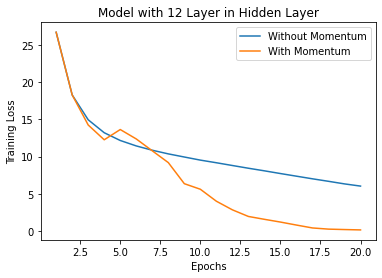

In [11]:
plt.plot(np.arange(1,21),losses[0],label='Without Momentum')
plt.plot(np.arange(1,21),losses[1],label='With Momentum')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Model with 12 Layer in Hidden Layer")
plt.savefig('12.png')

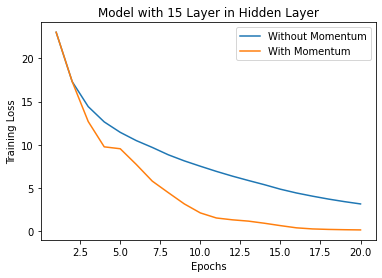

In [12]:
plt.plot(np.arange(1,21),losses[2],label='Without Momentum')
plt.plot(np.arange(1,21),losses[3],label='With Momentum')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Model with 15 Layer in Hidden Layer")
plt.savefig('15.png')